In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import itertools
import time
from IPython.display import clear_output

import scipy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms

import pickle
import os
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
from dgm_utils import train_model
# from seminar13_utils import train_model

# <center>Deep Generative Models</center>
## <center>Seminar 13</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>05.12.2022</center>


## Plan

1. CNF recap
    
    - Instantaneous Change-of-Variables formula

2. Langevin dynamics and Score Matching

    - Langevin dynamics recap
    - Implicit score matching
    - Sliced score matching
    - Denoising score matching

## CNF recap

Link to the [article](https://arxiv.org/pdf/1810.01367.pdf)

$$
\begin{cases}
d \mathbf{z}(t) = f(\mathbf{z}(t), t) d t \\
\mathbf{z}(0) \sim p_{z_0}
\end{cases}
$$

<center><img src="pics/cnf.png" width=800 /></center>

**Question**. In order to apply the NeuralODE solver one need to define a loss function $L$ which assesses the output of the dynamics. Which loss function is used in **CNF** case?

$$L\big{(}\mathbf{z}_0, \log p(\mathbf{x}) - \log p_{z_0}(\mathbf{z}_0)\big{)} = - \big{(}p_{z_0}(\mathbf{z}_0) + \log p(\mathbf{x}) - \log p_{z_0}(\mathbf{z}_0)\big{)}$$

### Instantanious CoV formula

$$
\frac{d \log p(\mathbf{z}(t), t)}{d t} = - \text{trace} \left(\frac{\partial f}{\partial \mathbf{z}(t)}\right) = - \text{div} f(\mathbf{z}(t))
$$

#### Stochastic Differential Equation (SDE)

$$
\begin{cases}
d \mathbf{z}(t) = f(\mathbf{z}(t), t) d t + g(t) d \mathbf{W} \\
\mathbf{z}(0) \sim p_{z_0}
\end{cases}
$$

$d \mathbf{W}$ is a "differential" of Wiener process

**Euler-Maruyama** simulation:

1. Sample $\mathbf{z}_{0} \sim p_{z_0}$

2. Fix $\tau > 0$ and for $k \in {0, 1, \dots K}$ do: 

$$\mathbf{z}_{(k + 1) \tau} = \mathbf{z}_{k \tau} + f(\mathbf{z}_{k \tau}, k \tau) \tau + g(k \tau) \Delta \mathbf{W}_k\, ,\\
\text{where } \Delta \mathbf{W}_k \sim \mathcal{N}(0, \tau I)$$

<center><img src="pics/em_demo.png" width=600 /></center>

### Fokker-Planck equation

The marginal pdfs of $\mathbf{z}(t)$ (governed by SDE) follows the **Fokker-Planck** equation:

$$
\begin{cases}
\frac{\partial p(\mathbf{z}, t)}{\partial t} = - \text{trace} \left(\frac{\partial}{\partial \mathbf{z}} \left[f(\mathbf{z}, t) p(\mathbf{z}, t)\right]\right) + \frac{1}{2} \text{trace} \left( g^2(t) \frac{\partial^2 p(\mathbf{z}, t)}{\partial \mathbf{z}^2}\right)\\
p(\cdot, 0) = p_{z_0}
\end{cases}
$$

**Fokker-Planck** equation without diffusion term:

$$
\begin{cases}
\frac{\partial p(\mathbf{z}, t)}{\partial t} = - \text{trace} \left(\frac{\partial}{\partial \mathbf{z}} \left[f(\mathbf{z}, t) p(\mathbf{z}, t)\right]\right) = - \text{div}_{\mathbf{z}} \left(f(\mathbf{z}, t) p(\mathbf{z}, t)\right)\\
p(\cdot, 0) = p_{z_0}
\end{cases}
$$

### Derivation of Instantanious CoV formula

- in jamboard

## Langevin Dynamics and Score Matching

The code and visualization are based on the following [github](https://github.com/acids-ircam/diffusion_models).

### Problem setup. Target distribution.

In [3]:
def train_test_split(data):
    count = data.shape[0]
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

def create_two_gaussians(noise):
    mix = TD.Categorical(torch.tensor([0.5, 0.5]).to(DEVICE))
    mv_normals = TD.MultivariateNormal(
        torch.tensor([[1., 1.], [-1., -1.]]).to(DEVICE),
        noise * torch.eye(2).unsqueeze(0).repeat_interleave(2, 0).to(DEVICE))
    return TD.MixtureSameFamily(mix, mv_normals)

GMM = create_two_gaussians(0.1)

Samples from target distribution

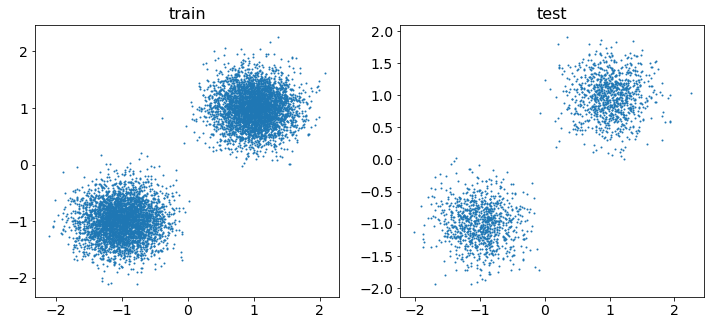

In [4]:
COUNT = 10000

train_data, test_data= train_test_split(GMM.sample((COUNT,)))
visualize_2d_data(train_data.cpu().numpy(), test_data.cpu().numpy())

### Langevin Dynamics

The **Langevin dynamics** is given by the following SDE:

$$
\begin{cases}
d \mathbf{z}(t) = \frac{1}{2}\nabla_{\mathbf{z}}\log p^*(\mathbf{z}(t)) d t + d \mathbf{W} \\
\mathbf{z}(0) \sim p_{z_0}
\end{cases}
$$

* In the above equation $p^*(\cdot)$ is a distribuiton of interest.
* $p^*(\cdot)$ is a **stationary** distribution of the process, i.e.: 

$$
p_{z}(\cdot, t) = p^*(\cdot) \Rightarrow p_{z}(\cdot, T) = p^*(\cdot) \text{ for } T \geq t
$$

* One expect the convergence $p_{z}(\cdot, t) \rightarrow p^*$ as $t \rightarrow \infty$ (given $p_{z_0}$ to be some prior distribution)
* Can be used for **Bayesian inference** (one of the MCMC approaches).
* Convergence analysis is **hard**.

**Score** function of the distribution $p^*(\cdot)$:

$$s(\mathbf{z}) = \nabla_{\mathbf{z}}\log p^*(\mathbf{z})$$

### Score function

In [5]:
from seminar13_utils import make_numpy

def plot_score_function(
    score_function, 
    data, 
    title, 
    plot_scatter=True, 
    xlim=(-2., 2.), 
    ylim=(-2., 2.), 
    npts=40, 
    ax=None, 
    figsize=(12, 12),
    scatter_label='GT labels',
    quiver_label = None,
    quiver_color='black'
):
    xx = np.stack(
        np.meshgrid(
            np.linspace(xlim[0], xlim[1], npts), 
            np.linspace(ylim[0], ylim[1], npts)), axis=-1).reshape(-1, 2)
    scores = score_function(torch.tensor(xx).float().to(DEVICE)).detach().cpu().numpy()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if (plot_scatter):
        np_data = make_numpy(data)
        ax.scatter(
            np_data[:, 0], np_data[:, 1], alpha=0.3, 
            color='red', edgecolor='white', s=40, label=scatter_label)
    ax.quiver(*xx.T, *scores_log1p.T, width=0.002, color=quiver_color, label=quiver_label)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(title, fontsize=16)
    return ax

In [6]:
### taken from seminar 6
from seminar13_utils import batch_jacobian

def get_gt_score_function(distribution):
    def score_function(x):
        x.requires_grad_(True) # (bs, 2)
        log_prob = distribution.log_prob(x).unsqueeze(-1) # (bs, 1)
        s_raw = batch_jacobian(
            x, log_prob, create_graph=False, retain_graph=False) # (bs, 1, 2)
        return s_raw.reshape(x.size(0), -1).detach()
    return score_function

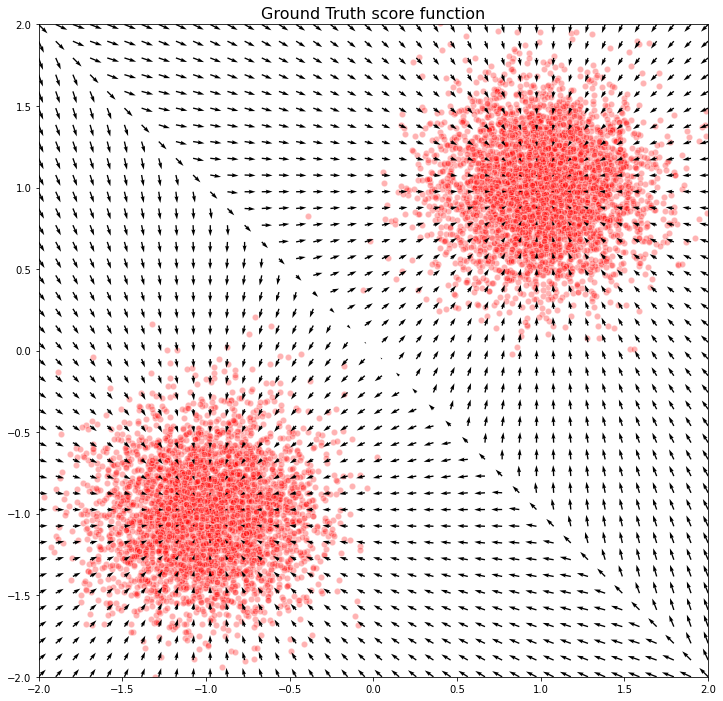

In [7]:
plot_score_function( get_gt_score_function(GMM), train_data, 'Ground Truth score function')
plt.show()

### Langevin dynamics simulation

**Euler-Maruyama** simulation of Langevin dynamics:

1. Sample $\mathbf{z}_{0} \sim p_{z_0}$

2. Fix $\tau > 0$ and for $k \in {0, 1, \dots K}$ do: 

$$\mathbf{z}_{(k + 1) \tau} = \mathbf{z}_{k \tau} + \tau \frac{1}{2} \nabla_{\mathbf{z}} \log p^*(\mathbf{z}_{k \tau}) + \Delta \mathbf{W}_k\, ,\\
\text{where } \Delta \mathbf{W}_k \sim \mathcal{N}(0, \tau I)$$

Properties:

* Approximates Langevin dynamics given $\tau > 0$ small enough. It is worth to anneal $\tau$ during simulation.

* Stochastic analogue of gradient ascent algorithm

In [78]:
def draw_dynamics(dynamics, ax, s=50, linewidth=2):
    np_dynamics = make_numpy(dynamics)
    ax.scatter(np_dynamics[:, 0], np_dynamics[:, 1], color='green', edgecolor='white', s=s, label='langevin dynamics')
    # draw arrows for each mcmc step
    deltas = (np_dynamics[1:] - np_dynamics[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        ax.arrow(
            np_dynamics[i,0], np_dynamics[i,1], 
            arrow[0], arrow[1], 
            width=1e-4, head_width=2e-2, color="green", linewidth=linewidth)

In [79]:
def sample_langevin(score_function, x, n_steps=100, eps=1e-2, decay=1.0, store_history=False):
    if store_history:
        x_sequence = [x.detach().cpu()]

    for s in range(n_steps):

        ## Langevin dynamics
        z_t = torch.randn(x.size()).to(x)
        x = x + (eps / 2) * score_function(x) + (np.sqrt(eps) * z_t)
        eps *= decay

        if store_history:
            x_sequence.append(x.detach().cpu())
    if store_history:
        return x, torch.cat(x_sequence)
    return x

Euler-Maruyama simulation of Langevin dynamics example

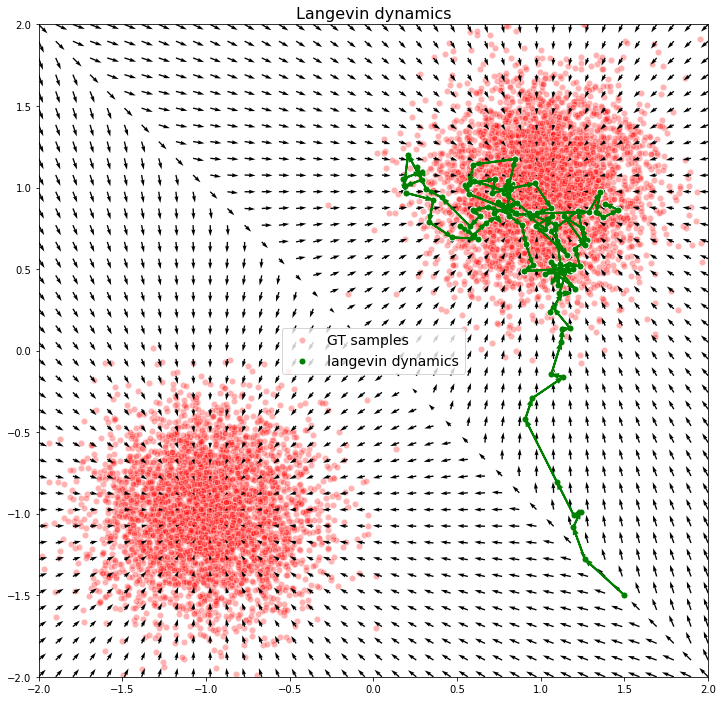

In [194]:
ax = plot_score_function(get_gt_score_function(GMM), train_data, 'Langevin dynamics')
x = torch.Tensor([[1.5, -1.5]]).to(DEVICE)
final_x, samples = sample_langevin(get_gt_score_function(GMM), x, store_history=True)
draw_dynamics(samples, ax)
plt.legend(fontsize=14)
plt.show()

#### Convergence of Langevin dynamics

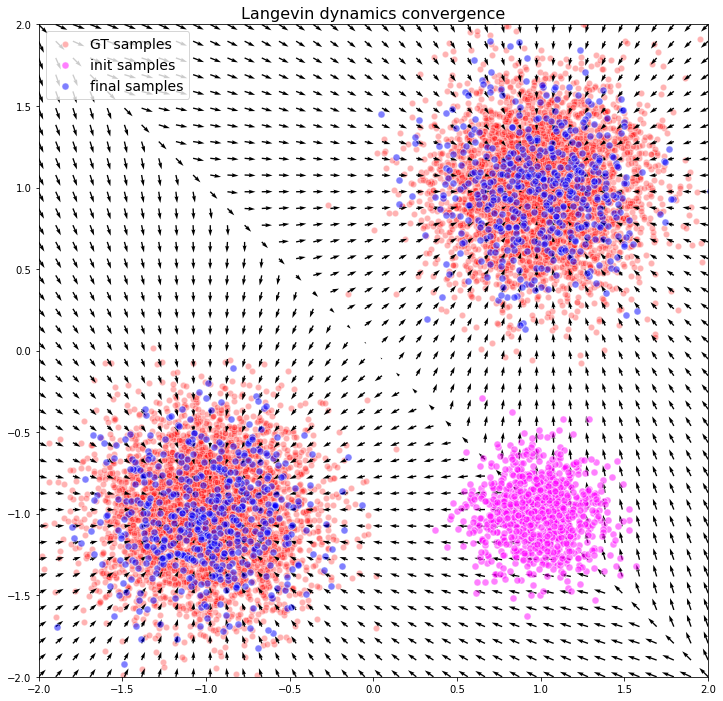

In [195]:
init_distrib = TD.Normal(
    torch.tensor([1., -1.]).to(DEVICE),
    torch.tensor([0.2, 0.2]).to(DEVICE))

init_distrib_samples = init_distrib.sample((1000,))

ax = plot_score_function(get_gt_score_function(GMM), train_data, 'Langevin dynamics convergence')
final_samples = sample_langevin(get_gt_score_function(GMM), init_distrib_samples)
ax.scatter(
    make_numpy(init_distrib_samples)[:, 0], 
    make_numpy(init_distrib_samples)[:, 1], 
    color='magenta', edgecolor='white', 
    s=50, alpha=0.5, label='init samples')
ax.scatter(
    make_numpy(final_samples)[:, 0], 
    make_numpy(final_samples)[:, 1], 
    color='blue', edgecolor='white', 
    s=50, alpha=0.5, label='final samples')
plt.legend(fontsize=14)
plt.show()

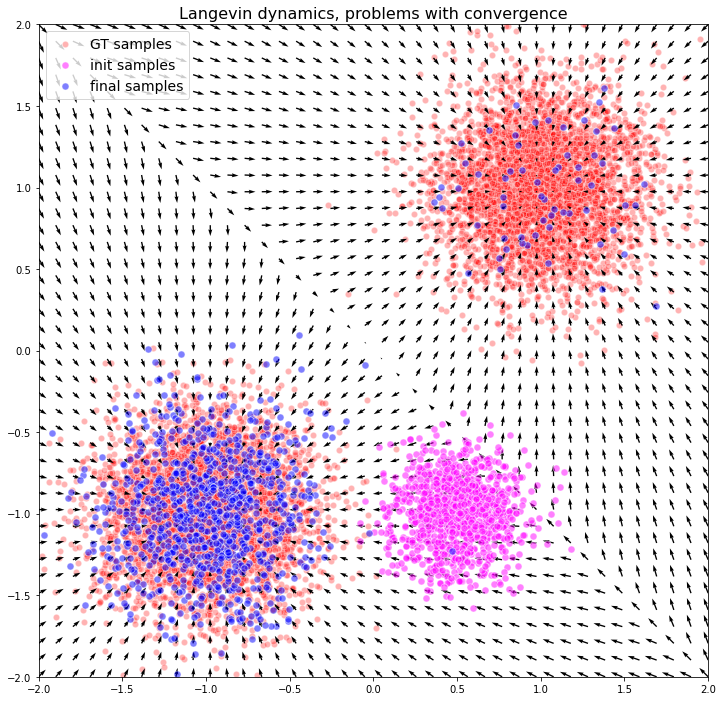

In [199]:
init_distrib = TD.Normal(
    torch.tensor([0.5, -1.]).to(DEVICE),
    torch.tensor([0.2, 0.2]).to(DEVICE))

init_distrib_samples = init_distrib.sample((1000,))

ax = plot_score_function(get_gt_score_function(GMM), train_data, 'Langevin dynamics, problems with convergence')
final_samples = sample_langevin(get_gt_score_function(GMM), init_distrib_samples)
ax.scatter(
    make_numpy(init_distrib_samples)[:, 0], 
    make_numpy(init_distrib_samples)[:, 1], 
    color='magenta', edgecolor='white', 
    s=50, alpha=0.5, label='init samples')
ax.scatter(
    make_numpy(final_samples)[:, 0], 
    make_numpy(final_samples)[:, 1], 
    color='blue', edgecolor='white', 
    s=50, alpha=0.5, label='final samples')
plt.legend(fontsize=14)
plt.show()

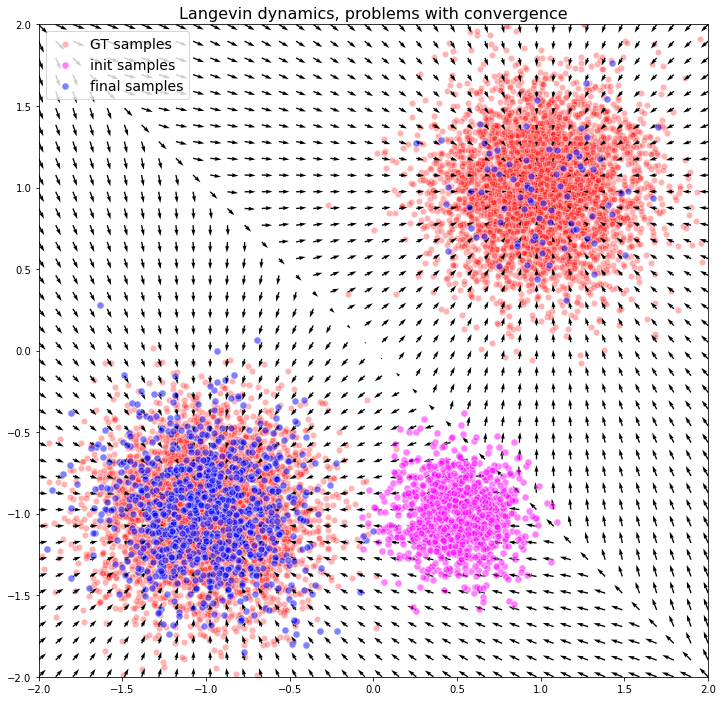

In [200]:
init_distrib = TD.Normal(
    torch.tensor([0.5, -1.]).to(DEVICE),
    torch.tensor([0.2, 0.2]).to(DEVICE))

init_distrib_samples = init_distrib.sample((1000,))

ax = plot_score_function(get_gt_score_function(GMM), train_data, 'Langevin dynamics, problems with convergence')
final_samples = sample_langevin(get_gt_score_function(GMM), init_distrib_samples, n_steps=10000)
ax.scatter(
    make_numpy(init_distrib_samples)[:, 0], 
    make_numpy(init_distrib_samples)[:, 1], 
    color='magenta', edgecolor='white', 
    s=50, alpha=0.5, label='init samples')
ax.scatter(
    make_numpy(final_samples)[:, 0], 
    make_numpy(final_samples)[:, 1], 
    color='blue', edgecolor='white', 
    s=50, alpha=0.5, label='final samples')
plt.legend(fontsize=14)
plt.show()

**Conclusion**

In general, Langevin dynamics convergence is slow (for example, for multimodal case)

**Question**

But yet, how to model **score** function given we know only sampels $X \sim p^*$?

## Score matching

Was proposed in [Song et. al., 2019](https://arxiv.org/pdf/1905.07088.pdf), inspired by [Hyv ̈arinen et. al., 2005](https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf)

**What we want**:

$$
s(\mathbf{z}| \theta) \approx \nabla_{\mathbf{z}}\log p^*(\mathbf{z})
$$

**Optimization problem:**

$$
L_{\text{MSE}}(\theta) = \frac{1}{2}E_{\mathbf{\mathbf{z}} \sim p^*(\mathbf{z})} \left[ \left\lVert s(\mathbf{z}|\theta) - \nabla_{\mathbf{z}} \log p^*(\mathbf{z}) \right\lVert_2^2 \right] \rightarrow \min\limits_{\theta}
$$

Equivalent formulation **(Implicit Score Matching):**

$$ L_{\text{matching}}(\theta) = E_{\mathbf{z} \sim p^*(\mathbf{z})} \left[ \text{trace}\left(\nabla_{\mathbf{z}}  s(\mathbf{z}|\theta)  \right) + \frac{1}{2} \left\Vert s(\mathbf{z}|\theta) \right\lVert_2^2 \right]
$$

In [74]:
# Taken from seminar 6
from seminar13_utils import FullyConnectedMLP

class ScoreFunction(FullyConnectedMLP):

    def __init__(self, dim=2, hiddens=[128, 128]):
        super().__init__(dim, hiddens, dim, activation_gen = lambda : nn.Softplus())

In [24]:
class ScoreFunciton_VanillaMatching(ScoreFunction):

    def loss(self, samples):
        with torch.enable_grad():
            samples.requires_grad_(True)
            score = self.forward(samples)
            # Compute the norm loss
            norm_loss = torch.norm(score, dim=-1) ** 2 / 2.
            # Compute the Jacobian loss
            jacob_mat = batch_jacobian(samples, score)
            tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
            score_matching = (tr_jacobian_loss + norm_loss).mean()
            return {'score_matching': score_matching}

In [35]:
EPOCHS = 50
BATCH_SIZE = 256
LR = 1e-3
USE_CUDA=True

score_model = ScoreFunciton_VanillaMatching().cuda()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    score_model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='score_matching'
)

  0%|          | 0/50 [00:00<?, ?it/s]

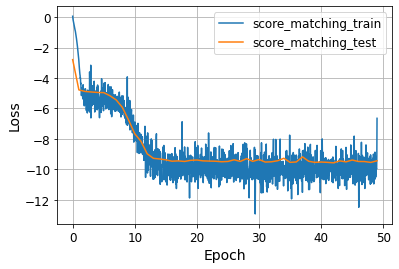

In [36]:
plot_training_curves(train_losses, test_losses)

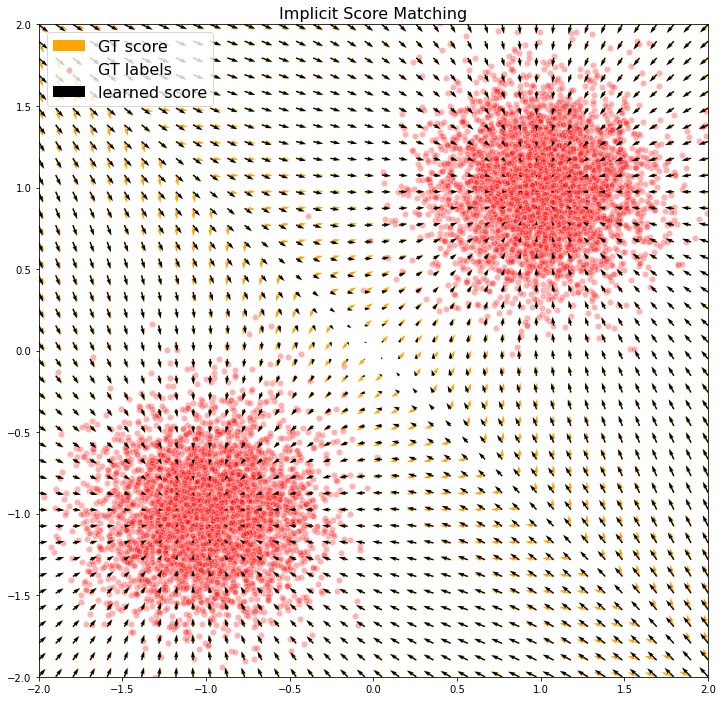

In [38]:
ax = plot_score_function(
    get_gt_score_function(GMM), train_data, 'Ground Truth score function', 
    plot_scatter=False, quiver_color='orange', quiver_label='GT score')
plot_score_function(score_model, train_data, 'Implicit Score Matching', 
                    ax = ax, quiver_label='learned score')
plt.legend(fontsize=16)
plt.show()

### Sliced Score matching

Proposed in [Song et. al., 2019](https://arxiv.org/pdf/1905.07088.pdf)

$$L_{\text{sliced matching}}(\theta) = E_{\mathbf{v} \sim p_v} E_{\mathbf{z} \sim p^*(\mathbf{z})} \left[ \mathbf{v}^T \nabla_{\mathbf{z}}  s(\mathbf{z}|\theta) \mathbf{v} + \frac{1}{2} \left( \mathbf{v}^T s(\mathbf{z}|\theta) \right)^2 \right]
, $$

* The distribution $p_v$ satisfies $E(p_v) = 0$, $\text{Var}(p_v) = I$

In [39]:
class ScoreFunciton_SlicedMatching(ScoreFunction):

    def __init__(self, *args, proj_distrib='normal', **kwargs):
        super().__init__(*args, **kwargs)
        assert proj_distrib in ['normal', 'rademacher', 'unit_sphere']
        self.proj_distrib = proj_distrib

    def proj_distrib_sample(self, shape):
        if self.proj_distrib == 'normal':
            return torch.randn(shape)
        if self.proj_distrib == 'unit_sphere':
            v = torch.randn(shape)
            v = v / torch.norm(v, dim=-1, keepdim=True)
            return v
        if self.proj_distrib == 'rademacher':
            return (torch.rand(shape) < 0.5).float() * 2. - 1.
        raise NotImplementedError()

    def loss(self, samples):
        with torch.enable_grad():
            assert len(samples.shape) == 2
            vectors = self.proj_distrib_sample(samples.shape).to(samples)
            # Compute the optimized vector-product jacobian
            # it is just syntax sugar over torch.autograd.grad
            # score = model(samples)
            # vjp = vectors^T Jac(model)_{samples}
            score, vjp = torch.autograd.functional.vjp(
                self, samples, vectors, create_graph=True)
            # Compute the norm loss
            norm_loss = 0.5 * (score * vectors).sum(-1).pow(2).mean()
            # Compute the Jacobian loss
            jacob_loss = (vjp * vectors).sum(-1).mean()
            score_matching = jacob_loss + norm_loss
            return {'score_matching': score_matching}

**Question**: What the difference between `jvp` and `vjp`?

In [84]:
EPOCHS = 60
BATCH_SIZE = 256
LR = 1e-3
USE_CUDA=True

score_model = ScoreFunciton_SlicedMatching(proj_distrib='rademacher').cuda()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    score_model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='score_matching'
)

  0%|          | 0/60 [00:00<?, ?it/s]

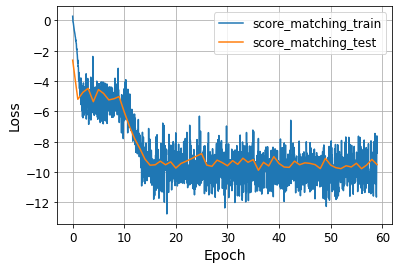

In [85]:
plot_training_curves(train_losses, test_losses)

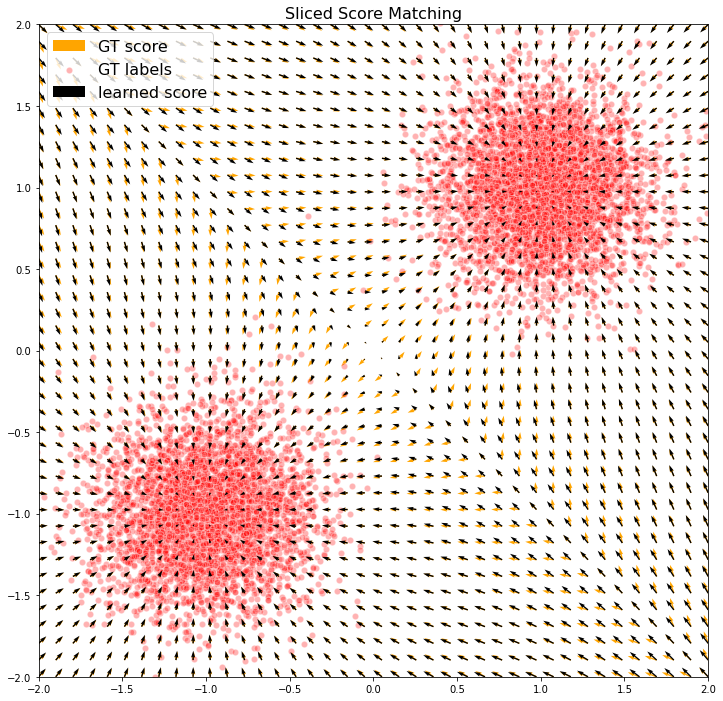

In [86]:
ax = plot_score_function(
    get_gt_score_function(GMM), train_data, 'Ground Truth score function', 
    plot_scatter=False, quiver_color='orange', quiver_label='GT score')
plot_score_function(score_model, train_data, 'Sliced Score Matching', 
                    ax = ax, quiver_label='learned score')
plt.legend(fontsize=16)
plt.show()

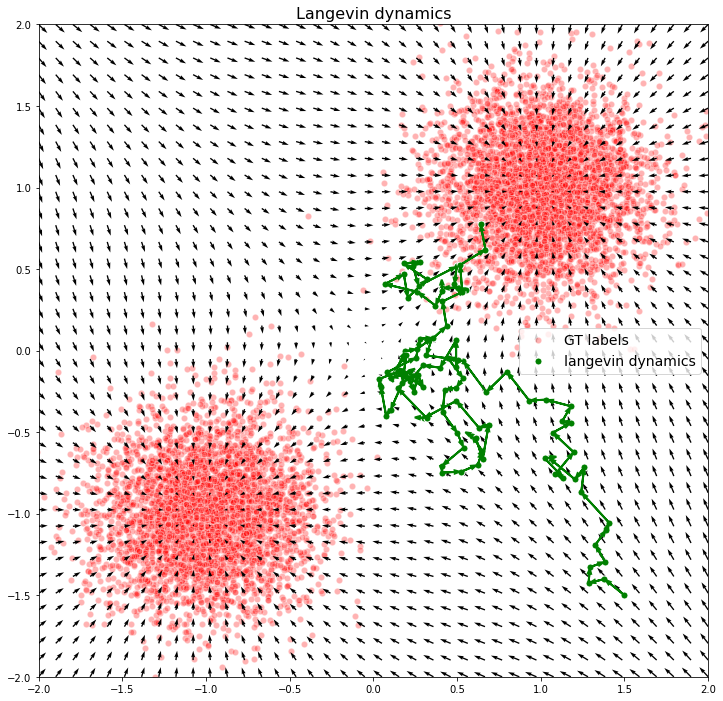

In [89]:
ax = plot_score_function(score_model, train_data, 'Langevin dynamics')
x = torch.Tensor([[1.5, -1.5]]).to(DEVICE)
final_x, samples = sample_langevin(score_model, x, store_history=True)
draw_dynamics(samples, ax)
plt.legend(fontsize=14)
plt.show()

**Conclusion**:

Vanilla (and Slicing) score matching result in **pore** score function approximation in the areas of low probability mass (w.r.t. $p^*(\mathbf{z})$)

### Denoising score matching

Was discussed by [Vincent et. al., 2010](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)

Consider **noising kernel**:

$$ q_{\sigma}(\mathbf{z} | \mathbf{z}') = \mathcal{N}(\mathbf{z} | \mathbf{z}', \sigma^2 I)$$

Noised distribution of interest:

$$ p^*_{\sigma}(\mathbf{z}) = \int\limits_{\mathbf{Z}} q_{\sigma}(\mathbf{z} | \mathbf{z}') p^*(\mathbf{z}') d \mathbf{z}' $$

**Optimization problem**:


$$
L_{\text{MSE noised}}(\theta) = \frac{1}{2}E_{\mathbf{\mathbf{z}} \sim p^*_{\sigma}(\mathbf{z})} \left[ \left\lVert s_{\sigma}(\mathbf{z}|\theta) - \nabla_{\mathbf{z}} \log p^*_{\sigma}(\mathbf{z}) \right\lVert_2^2 \right] \rightarrow \min\limits_{\theta}
$$

Alternative formulation **(Denoising score matching)** (proof can be found in [Vincent et. al., 2010](http://www-labs.iro.umontreal.ca/~vincentp/Publications/smdae_techreport_1358.pdf)):

$$
L_{\text{denoising matching}}(\theta) = \frac{1}{2}E_{\mathbf{z}' \sim p^*(\cdot)} E_{\mathbf{z} \sim q_{\sigma}(\mathbf{z} | \mathbf{z}')}  \left[ \left\Vert s_{\sigma}(\mathbf{z}|\theta) - \nabla_{\mathbf{z}} \log q_{\sigma}(\mathbf{z}\mid\mathbf{z}') \right\lVert_2^2 \right] = \\
= \frac{1}{2}E_{\mathbf{z}' \sim p^*(\cdot)} E_{\mathbf{z} \sim q_{\sigma}(\mathbf{z} | \mathbf{z}')}  \left[ \left\Vert s_{\sigma}(\mathbf{z}|\theta) + \frac{\mathbf{z} - \mathbf{z}'}{\sigma^{2}} \right\lVert_2^2 \right] \rightarrow \min\limits_{\theta}
$$

In [44]:
class ScoreFunciton_DenoisingMatching(ScoreFunction):

    def __init__(self, *args, sigma=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.sigma = sigma

    def loss(self, samples):
        assert len(samples.shape) == 2
        pert_samples = samples + torch.randn_like(samples) * self.sigma
        target = - 1 / (self.sigma ** 2) * (pert_samples - samples)
        scores = self.forward(pert_samples)
        bs = target.size(0)
        denoised_score_matching_loss = 0.5 * ((
            scores.view(bs, -1) - target.view(bs, -1)) ** 2).sum(dim=-1).mean(dim=0)
        return {'score_matching': denoised_score_matching_loss}

In [68]:
EPOCHS = 100
BATCH_SIZE = 256
LR = 1e-3
USE_CUDA=True
SIGMA = 0.5

score_model = ScoreFunciton_DenoisingMatching(sigma=SIGMA).cuda()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    score_model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='score_matching'
)

  0%|          | 0/100 [00:00<?, ?it/s]

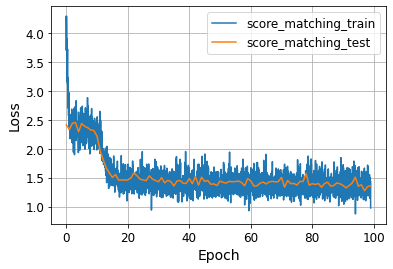

In [69]:
plot_training_curves(train_losses, test_losses)

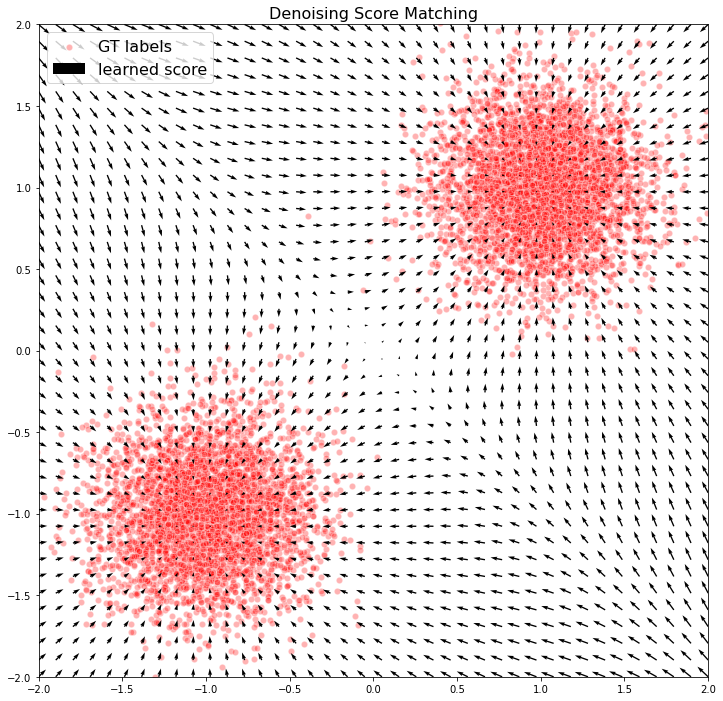

In [70]:
# ax = plot_score_function(
#     get_gt_score_function(GMM), train_data, 'Ground Truth score function', 
#     plot_scatter=False, quiver_color='orange', quiver_label='GT score')
plot_score_function(score_model, train_data, 'Denoising Score Matching', quiver_label='learned score')
plt.legend(fontsize=16)
plt.show()

Check with `Implicit score matching` model:

In [71]:
class NoisedDataset:

    def __init__(self, dataset, sigma=0.1):
        self.dataset = dataset
        self.sigma = sigma

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        item = self.dataset[i]
        return item + torch.randn_like(item) * self.sigma

In [72]:
EPOCHS = 50
BATCH_SIZE = 256
LR = 1e-3
USE_CUDA=True

vanilla_score_model = ScoreFunciton_VanillaMatching().cuda()
train_loader = DataLoader(NoisedDataset(train_data, sigma=SIGMA), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(NoisedDataset(test_data, sigma=SIGMA), batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    vanilla_score_model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='score_matching'
)

  0%|          | 0/50 [00:00<?, ?it/s]

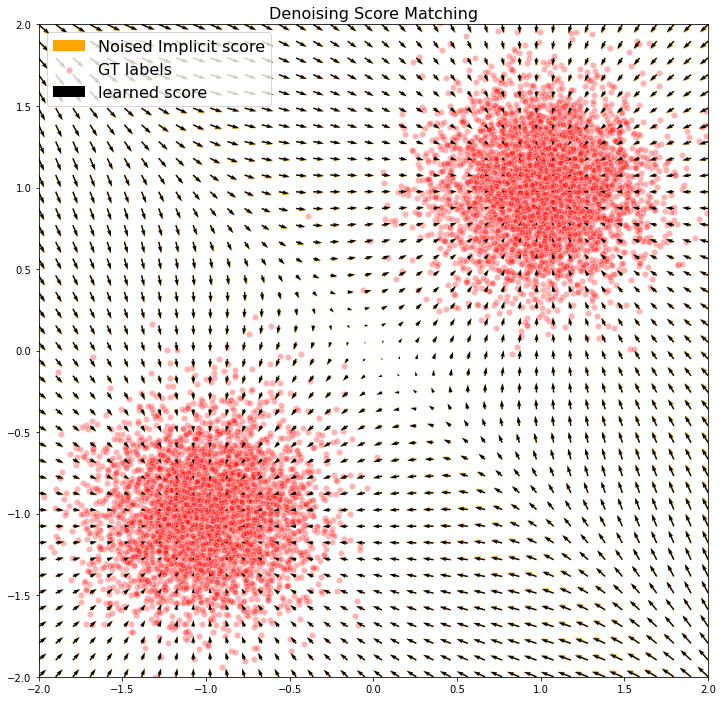

In [73]:
ax = plot_score_function(
    vanilla_score_model, train_data, '', 
    plot_scatter=False, quiver_color='orange', quiver_label='Noised Implicit score')
plot_score_function(score_model, train_data, 'Denoising Score Matching', 
                    ax = ax, quiver_label='learned score')
plt.legend(fontsize=16)
plt.show()